#### Ген

In [ ]:
from enum import Enum # библиотека для создания и использования перечислений
import random

In [ ]:
class ConnectionType(Enum):
    INPUT = 1      # именованное значение
    OUTPUT = 2

    @classmethod
    def from_label(cls, label: int):
        return cls(cls.OUTPUT if label > (2**7 - 1) else cls.INPUT)

In [ ]:
# СКРЕЩИВАНИЕ МЕЖДУ ДВУМЯ ЦЕЛЫМИ ЧИСЛАМИ (МЕТКАМИ)

def crossover_integer(parent1: int, # первая родительская целочисленная метка
                      parent2: int, # вторая родительская целочисленная метка
                      precision: int): # точность (количество битов, используемых для представления чисел)
    crossover_point = random.randrange(precision) #  случайня точка, где будет происходить разделение
    #  строчка кода вычисляет маску, где все биты ниже precision равны 1, а все биты выше precision равны 0
    #  выбибраемь определенные биты в генотипе на основе точки кроссовера
    # & - ПОБИТОВАЯ операция И
    mask1 = ((2 ** precision - 1) << crossover_point) & (2 ** precision - 1)  # <<crossover_point - это побитовый сдвиг влево на crossover_point разрядов
    mask2 = ((2 ** precision - 1) >> (precision - crossover_point)) & (2 ** precision - 1)
    #  parent1 & mask1 - это операция побитового "И"
    #  Оставляем только те биты в parent1, которые в маске mask1 равны 1, а все остальные биты становятся 0.
    child1 = (parent1 & mask1) | (parent2 & mask2) # побитовое "ИЛИ".объединяем оба результата. в итоге получается новое число child1.
    child2 = (parent2 & mask1) | (parent1 & mask2)
    return child1, child2

In [ ]:
# СКРЕЩИВАНИЕ ДВУХ ГЕНОВ (RealGene)
# принимает два вещественных значения родительских генов и возвращает два вещественных значения дочерних генов
def crossover_real(parent1: float, parent2: float, blend=0.1):
    child1 = parent1 - blend * (parent2 - parent1) # новое число в интевале от parent1 до parent2
    child2 = parent2 + blend * (parent2 - parent1)
    return child1, child2

In [ ]:
# функция invert_bit используется для инвертирования значения определенного бита в целочисленном числе value.
def invert_bit(value: int, # целочисленное значение, бит которого требуется инвертировать
               bit: int, # позиция бита в числе value, который должен быть инвертирован
               precision: int): # точность (количество бит) числа value
    mask = (1 << bit) & (2 ** precision - 1) # все биты в mask, кроме бита на позиции bit, будут равны 0, а бит на позиции bit будет равен 1.
    return value ^ mask # побитовая операция "ИСКЛЮЧАЮЩЕЕ ИЛИ"

In [ ]:
# Класс RealGene реализует логику работы с одним геном, использующим вещественное кодирование
class RealGene(object):
    def __init__(self, value: float, min_value: float, max_value: float):
        self.value = value          # вещественное значение гена
        self.min_value = min_value  # минимальное случайно сген. число
        self.max_value = max_value  # максимальное случайно сген. число

    # инициализация векторов входных и выходных весов случайными значениями
    def init(self):
        self.value = random.uniform(self.min_value, self.max_value) # случайное значение, полученное из равномерного распределения в диапазоне от min_value до max_value

    # мутация векторов весов, используется нормальное распределение в окрестности значения гена
    def mutation(self):
        self.value = random.gauss(mu=self.value, sigma=0.1)   # случайное значение, полученное из нормального распределения с заданным средним и стандартным отклонением

    # СКРЕЩИВАНИЕ ДВУХ НЕЙРОНОВ, используется скрещивание смешением; в качестве результата возвращаются два новых нейрона
    @staticmethod    #  метод не имеет доступа к экземпляру класса или к атрибутам экземпляра
    def crossover(parent1, parent2):     # parent1 и parent2 - экзепляры класса RealGene
        min_value = parent1.min_value
        max_value = parent1.max_value
        child1_gene, child2_gene = crossover_real(    # скрещивание двух генов
            parent1=parent1.value,
            parent2=parent2.value)
        child1 = RealGene(          # первый нейрон потомок
            value=child1_gene,
            min_value=min_value,
            max_value=max_value)
        child2 = RealGene(          # второй нейрон потомок
            value=child2_gene,
            min_value=min_value,
            max_value=max_value)
        return child1, child2

In [ ]:
# Класс Gene реализует логику работы с одним геном, хранящим вес и структуру нейрона
class Gene(object):
    def __init__(self, min_value: float, max_value: float):
        self.label = 0    # целочисленное значение, хранящее направление связи (входная или выходная) и индекс нейрона, с которым установлена связь
        #self.weight = IntegerGene(
        #    value=0.0,
        #    min_value=min_value,
        #    max_value=max_value,
        #    precision=32)
        self.weight = RealGene(                         # вес связи, объект класса RealGene
            value=0.0,
            min_value=min_value,
            max_value=max_value)

    def get_connection_type(self) -> ConnectionType:    # метод, возвращает направление соединения (label > 127 - нейрон выходной, иначе входной)
        return ConnectionType.from_label(self.label)

    def get_index(self, neurons_count) -> int:          # метод возвращает индекс нейрона
        return self.label % neurons_count

    def get_weight(self) -> float:                      # метод возвращает вес связи
        return self.weight.value

    def init(self):
        self.label = int(random.random() * (2**8 - 1))  # инициализация метки случайным числом от 0 до 255
        self.weight.init()                              # инициализация веса связи

    # мутация весов и меток; для метки используется инвертирование бита; для веса вызывается метод mutation класса RealGene
    def mutation(self):
      # мутация произойдет с вероятностью 0.01 (1 %)
        if random.random() <= 0.01:
            mutation_bit = random.randrange(8)  # генерация случайного числа от 0 до 8. Получаем номер бита, который будем инвертировать
            self.label = invert_bit(self.label, mutation_bit, 8) # инвертируем полученный ранее номер бита метки
            self.weight.mutation()    # мутация веса связи

    # скрещивание двух генов; для метки используется одноточечный кроссинговер; для веса вызывается метод crossover класса RealGene
    @staticmethod
    def crossover(parent1, parent2):    # parent1 и parent2 - экзепляры класса Gene
        min_value = parent1.weight.min_value
        max_value = parent1.weight.max_value
        child1 = Gene(                   # потомок 1
            min_value=min_value,
            max_value=max_value)
        child2 = Gene(                   # потомок 2
            min_value=min_value,
            max_value=max_value)
        child1.label, child2.label = crossover_integer(      # скрещивание метки
            parent1=parent1.label,
            parent2=parent2.label,
            precision=8)
        #child1.weight, child2.weight = IntegerGene.crossover(
        #    parent1=parent1.weight,
        #    parent2=parent2.weight)
        child1.weight, child2.weight = RealGene.crossover(   # скрещивание весов
            parent1=parent1.weight,
            parent2=parent2.weight)
        return child1, child2

#### Хромосома (нейрон)

In [ ]:
import numpy as np

In [ ]:
# класс Neuron реализует логику работы с нейроном
class Neuron(object):
    def __init__(self,
                 connections_count: int):
        self.genes = []                              # список, хранящий гены (объекты класса Gene)
        self.connections_count = connections_count   # количество соединиений в одном нейроне (подразумевается, что сеть может быть не полносвязной)
        self.fitness = 0.0                           # приспособленность нейрона


    # инициализация нейрона. Инициализация происходит в цикле, в котором создаются гены со случайными значениями полей и в конце итерации проверяется,
    # что гены имеют разные направления соединений.
    # Это необходимо для того, чтобы не получился нейрон, имеющий связи одного направления, поскольку такая конфигурация нейрона не будет иметь смысла
    def init(self,
             min_value: float,
             max_value: float):
        while True:
            for i in range(self.connections_count):    # количество генов в хромосоме также равно connections_count
                self.genes.append(Gene(                # добавляем гены в хромосому
                    min_value=min_value,
                    max_value=max_value))
            for i in range(self.connections_count):
                self.genes[i].init()   # инициализируем метку и вес связи
            connection_types = [connection.get_connection_type().value for connection in self.genes]
            if len(set(connection_types)) > 1:
                break
            self.genes.clear()

    # получение вектора весов из генов соответсвующего направления
    def get_weights(self,
                    neurons_count: int,    # количество нейронов в скрытом слое (необходимо для вычисления индекса нейрона входного либо выходного слоев)
                    connection: ConnectionType) -> np.array:   # напрадение соединения
        result = np.zeros(neurons_count)
        for gene in self.genes:
            if gene.get_connection_type() == connection:
                result[gene.get_index(neurons_count)] = gene.get_weight()
        return result
    # получение вектора весов входных соединений скрытого слоя
    def get_input_weights(self,
                          neurons_count: int) -> np.array:   # количество нейронов в скрытом слое
        return self.get_weights(
            neurons_count=neurons_count,
            connection=ConnectionType.INPUT)

    # получение вектора весов выходных соединений скрытого слоя
    def get_output_weights(self,
                           neurons_count: int) -> np.array:  # количество нейронов в скрытом слое
        return self.get_weights(
            neurons_count=neurons_count,
            connection=ConnectionType.OUTPUT)

    # мутация генов. Вызывается метод mutation класса Gene для каждого нега
    def mutation(self):
        for i in range(len(self.genes)):
            self.genes[i].mutation()

    # скрещивание двух нейронов. Вызывается метод mutation класса Gene для каждого гена
    @staticmethod
    def crossover(parent1, parent2):
        genes_count = len(parent1.genes)
        connections_count = parent1.connections_count
        child1 = Neuron(
            connections_count=connections_count)
        child2 = Neuron(
            connections_count=connections_count)
        for i in range(genes_count):
            child1_gene, child2_gene = Gene.crossover(
                parent1=parent1.genes[i],
                parent2=parent2.genes[i])
            child1.genes.append(child1_gene)
            child2.genes.append(child2_gene)
        return child1, child2

#### Популяция нейронов

In [ ]:
# Класс NeuronPopulation реализует логику работы с популяцией нейронов, предоставляя высокоуровневый интерфейс над массивом нейронов
class NeuronPopulation(object):
    def __init__(self,
                 population_size: int,
                 connections_count: int):
        self.neurons = []                       # Массив нейронов
        for i in range(population_size):        # Создание популяции нейронов
            self.neurons.append(Neuron(
                connections_count=connections_count))

    def init(self,
             min_value: float,
             max_value: float):
        for neuron in self.neurons:             # инициализация нейронов в популяции. Для каждого нейрона вызывается метод init, в который передаются параметры входа
            neuron.init(
                min_value=min_value,
                max_value=max_value)

    # скрещивание верхней четверти лучших нейронов. Потомки при этом заменяют худшие особи
    def crossover(self):
        self.neurons.sort(key=lambda x: x.fitness)           # сортировка массива нейронов по функции приспособленности
        selected_neuron_count = int(len(self.neurons) / 4)   # выбираем из массива нейронов верхнюю четверть нейронов с лучшими значениями функции приспособленности
        selected_neuron_count -= selected_neuron_count % 2   # оставляем четное количество нейронов в списке
        for i in range(0, selected_neuron_count, 2):
            parent1 = self.neurons[i]
            parent2 = self.neurons[i + 1]
            child1, child2 = Neuron.crossover(
                parent1=parent1,
                parent2=parent2)
            selected1 = parent1 if random.randrange(2) == 0 else parent2        # после скрещивания остается только 1 случайный потомок
            selected2 = child1 if random.randrange(2) == 0 else child2          # вместо второго потомка используется один из родителей
            self.neurons[-selected_neuron_count + i] = selected1                # обновляем нейроны в списке
            self.neurons[-selected_neuron_count + i + 1] = selected2            # обновляем нейроны в списке

    def mutation(self):
        for i in range(len(self.neurons)):
            self.neurons[i].mutation()                       # мутация нейронов

    def __getitem__(self, key: int) -> Neuron:               # встроенный метод языка Python, позволяющий обращаться к данному объекту как к коллекции.
        return self.neurons[key]                             # при этом возвращается соответствующий индексу нейрон

    def __len__(self):                                       # встроенный метод языка Python, позволяющий получить размер коллекции.
        return len(self.neurons)                             # при этом возвращается размер массива нейронов

#### Blueprint (комбинация нейронов)

In [ ]:
from typing import List # используется для аннотации типов данных, чтобы указать, что переменная должна быть списком.

In [ ]:
# класс Blueprint - реализует логику работы с комбинацией  нейронов.
# комбинация рассматривается как отдельная особь
# хромосома - массив индексов нейронов

class Blueprint(object):
    def __init__(self,
                 neurons: List[int],  # массив индексов нейронов (комбинация нейронов)
                 neuron_population: NeuronPopulation):
        self.neurons = neurons                       # массив индексов нейронов
        self.neuron_population = neuron_population   # популяция нейронов (указатель на популяцию нейронов, поскольку данный объект не должен владеть популяцией)
        self.fitness = 0.0                           # значение приспособленности данной комбинации

    # мутация комбинации. В результате мутации происходит замена случайно выбранного нейрона в текущей комбинации на случайно выбранный нейрон из популяции нейронов
    def mutation(self):
        if random.random() <= 0.01:
            new_neuron_index = random.randrange(len(self.neuron_population))     # случайно выбранный нейрон в популяции нейронов
            neuron_index = random.randrange(len(self.neurons))                   # случайно выбранный нейрон в текущей комбинации
            self.neurons[neuron_index] = new_neuron_index                        # замена нейронов

    # скрещивание. Скрещиваются массивы индексов нейронов. Применяется одноточечный кроссинговер
    @staticmethod
    def crossover(parent1, parent2):
        neurons_count = len(parent1.neurons)              # длина комбинации нейронов
        crossover_point = random.randrange(neurons_count) # случайная точка для скрещивания комбинации
        child1_neurons = parent1.neurons[:crossover_point] + parent2.neurons[crossover_point:]  # скрещивание комбинаций нейронов
        child2_neurons = parent2.neurons[:crossover_point] + parent1.neurons[crossover_point:]  # скрещивание комбинаций нейронов
        return Blueprint(child1_neurons, None), Blueprint(child2_neurons, None)

#### Популяция комбинаций нейронов

In [ ]:
# Класс BlueprintPopulation - реализует логику работы с популяцией комбинаций нейронов, предоставляя высокоуровневый интерфейс над массивом комбинаций нейронов.
class BlueprintPopulation(object):
    def __init__(self,
                 population_size: int,
                 blueprint_size: int):
        self.population_size = population_size  # размер популяции (количество комбинаций в популяции)
        self.blueprint_size = blueprint_size    # размер комбинации нейронов (количество нейронов в комбинации). Должен быть равен количеству нейронов в скрытом слое
        self.neuron_population = None           # популяция нейронов
        self.blueprints = []                    # массив комбинаций нейронов


    # инициализация популяции комбинаций нейронов. Происходит создание комбинаций нейронов
    def init(self,
             neuron_population: NeuronPopulation):
        self.neuron_population = neuron_population   # создание объекта популяции нейронов
        for _ in range(self.population_size):
            selected_neurons = self.select_neurons() # отбор случайных нейронов из популяции нейронов
            self.blueprints.append(Blueprint(        # создание массива популяции комбинаций нейронов. Элементы массива объекты класса Blueprint
                neurons=selected_neurons,            # массив индексов выбранных нейронов
                neuron_population=self.neuron_population))  # популяция нейронов

    # внутренний метод, возвращающий список индексов случайно выбранных нейронов из популяции нейронов. При этом индексы являются уникальными
    def select_neurons(self) -> List[int]:
        result = []
        while True:                                  # формирование списка индексов
            for _ in range(self.blueprint_size):     # формирование одной комбинации нейронов
                result.append(random.randrange(len(self.neuron_population)))
            if len(set(result)) == self.blueprint_size:
                break
            result.clear()
        return result

    # мутация всех комбинаций нейронов
    def mutation(self):
        for blueprint in self.blueprints:
            blueprint.mutation()

    # скрещивание верхней четверти лучших комбинаций нейронов. Для скрещивания вызывается метод crossover класса Blueprint. Потомки при этом заменяют худшие особи
    def crossover(self):
        self.blueprints.sort(key=lambda x: x.fitness)             # сортировка массива комбинаций нейронов по функции приспособленности
        selected_blueprint_count = int(len(self.blueprints) / 4)  # выбираем из массива нейронов верхнюю четверть нейронов с лучшими значениями функции приспособленности
        selected_blueprint_count -= selected_blueprint_count % 2  # оставляем четное количество нейронов в списке
        for i in range(0, selected_blueprint_count, 2):
            parent1 = self.blueprints[i]
            parent2 = self.blueprints[i + 1]
            child1, child2 = Blueprint.crossover(
                parent1=parent1,
                parent2=parent2)
            child1.neuron_population = self.neuron_population
            child2.neuron_population = self.neuron_population
            selected1 = parent1 if random.randrange(2) == 0 else parent2  # после скрещивания остается только 1 случайный потомок
            selected2 = child1 if random.randrange(2) == 0 else child2    # вместо второго потомка используется один из родителей
            self.blueprints[-selected_blueprint_count + i] = selected1    # обновляем комбинации в списке
            self.blueprints[-selected_blueprint_count + i + 1] = selected2 # обновляем комбинации в списке

    # встроенный метод языка Python, позволяющий обращаться к данному объекту как к коллекции. При этом возвращается соответсвующий индексу нейрон
    def __getitem__(self, key: int) -> Blueprint:
        return self.blueprints[key]
    # встроенный метод языка Python, позволяющий получить размер коллекции. При это возвращается размер массива нейронов
    def __len__(self):
        return len(self.blueprints)
    # встроенный метод языка Python, позволяющий итерироваться по объекту. Итерация происходит по массиву комбинаций нейронов
    def __iter__(self):
        return iter(self.blueprints)

#### Функции активации

Базовым классом для всех функций активации является класс AbstractActivationFunction, представляющий интерфейс для работы с функциями активации. В данном классе имеется метод forward, который принимает на вход numpy-массив (вектор), применяет к каждому элементу функцию активации и возвращает numpy-массив. Дочерние классы должны реализовать данный метод.
Имеется реализация нескольких функций активации.

In [ ]:
class AbstractActivationFunction(object):
    def __init__(self):
        pass

    def forward(self, input_data: np.array) -> np.array:
        raise NotImplementedError()


class Sigmoid(AbstractActivationFunction):
    def __init__(self):
        pass

    def forward(self, input_data: np.array) -> np.array:
        return 1.0 / (1.0 + np.exp(-input_data))


class ReLU(AbstractActivationFunction):
    def __init__(self):
        pass

    def forward(self, input_data: np.array) -> np.array:
        return np.maximum(0.0, input_data)


class Tanh(AbstractActivationFunction):
    def __init__(self):
        pass

    def forward(self, input_data: np.array) -> np.array:
        return np.tanh(input_data)

#### Класс Layer

In [ ]:
# Класс Layer реализует логику работы со слоем нейронной сети
class Layer(object):
    def __init__(self,
                 weights: np.array,
                 activation: AbstractActivationFunction):
        self.weights = weights          # вектор весов
        self.activation = activation    # функция активации

    def forward(self,                                 # прямой проход по слою. Вектор весов умножается на вектор-столбец входных данных, к каждому элементу полученного вектора-столбца применяется функция активации
                input_data: np.array) -> np.array:    # вектор входных данных
        return self.activation.forward(
            input_data=np.dot(self.weights, input_data))

#### Класс NeuralNetwork

In [ ]:
class NeuralNetwork(object):
  # происходит инициализация весов нейронной сети и создание скрытого и выходного слоёв сети
    def __init__(self,
                 hidden_neurons: List[int],  # массив индексов нейронов, из которых будет построен скрытый слой
                 inputs_count: int,          # количество входов нейронной сети
                 outputs_count: int,         # количество выходов нейронной сети
                 neuron_population: NeuronPopulation):  # популяция нейронов, из которой будет происходить выборка нейронов
        self.fitness = 0.0      # приспособленность нейронной сети
        self.input_weights = np.zeros((len(hidden_neurons), inputs_count)) # матрица входных весов скрытого слоя
        output_weights = np.zeros((len(hidden_neurons), outputs_count))    # матрица выходных весов скрытого слоя (входных весов выходного слоя)
        for i in range(len(hidden_neurons)):
            self.input_weights[i] = neuron_population[hidden_neurons[i]].get_input_weights(inputs_count)
            output_weights[i] = neuron_population[hidden_neurons[i]].get_output_weights(outputs_count)
        self.output_weights = np.zeros((outputs_count, len(hidden_neurons)))
        for i in range(outputs_count):
            self.output_weights[i] = output_weights[:, i]
        self.layers = []                      # список, содержащий слои нейронной сети (объекты класса Layer)
        self.layers.append(Layer(             # создание скрытого слоя сети
            weights=self.input_weights,
            activation=Sigmoid()))
        self.layers.append(Layer(             # создание выходного слоя сети
            weights=self.output_weights,
            activation=Sigmoid()))

    # прямой проход по сети. Последовательно выполняется прямой проход по слоям сети с помощью метода forward класса Layer
    def forward(self,
                input_data: np.array) -> np.array: # вектор входных данных
        output = input_data
        for layer in self.layers:
            output = layer.forward(output)
        return output

#### Класс SANEAlgorithm

In [ ]:
import platform
import os
from copy import deepcopy

In [ ]:
def mse(y_true: np.array, y_pred: np.array) -> float:
    return np.square(y_true - y_pred).mean()

In [ ]:
# Строка кода определяет переменную CRLF в зависимости от операционной системы.
# Это позволяет корректно использовать символы новой строки в зависимости от платформы при выводе текста.
CRLF = '\r\x1B[K' if platform.system() != 'Windows' else '\r'

In [ ]:
# Класс SANEAlgorithm реализует логику работы с алгоритмом SANE
class SANEAlgorithm(object):
    def __init__(self,
                 blueprints_population_size: int,   # размер популяции комбинации нейронов
                 neuron_population_size: int,       # размер популяции нейронов
                 hidden_layer_size: int,            # количество нейронов скрытого слоя
                 connections_count: int):           # количество соединений для одного нейрона
        self.neuron_population = NeuronPopulation(  # популяция нейронов
            population_size=neuron_population_size,
            connections_count=connections_count)
        self.blueprint_population = BlueprintPopulation( # популяция комбинаций нейронов
            population_size=blueprints_population_size,
            blueprint_size=hidden_layer_size)
        self.best_nn = None                        # лучшая нейронная сеть

        self.hidden_layer_size = hidden_layer_size

    # инициализация популяции нейронов и популяции комбинаций нейронов
    def init(self,
             min_value: float,
             max_value: float):
        self.neuron_population.init(  # инициализация популяции нейронов
            min_value=min_value,
            max_value=max_value)
        self.blueprint_population.init(  # инициализация популяции комбинаций нейронов
            neuron_population=self.neuron_population)

    # тренировка нейронных сетей
    def train(self,
              generations_count: int,  # количество поколений
              x_train: np.array,       # массив входных данных
              y_train: np.array):      # массив выходных данных
        if x_train.shape[0] != y_train.shape[0]:
            raise Exception()
        result = []
        for generation in range(generations_count):
            inputs_count = x_train[0].size
            outputs_count = y_train[0].size

            neural_networks = self.create_neural_networks(   # создание нейронных сетей
                inputs_count=inputs_count,                   # количество входов нейронной сети
                outputs_count=outputs_count)                 # количество выходов нейронной сети
            self.forward_train(                              # пропускаем весь трейновый датасет через созданную НС
                neural_networks=neural_networks,
                x_train=x_train,
                y_train=y_train)

            neural_networks.sort(key=lambda x: x.fitness)    # сортировка НС по приспособленности
            best_nn = neural_networks[0]                     # выбираем лучшую нейронную сеть

            if self.best_nn is None:
                self.best_nn = deepcopy(best_nn)   # используется функция deepcopy, чтобы создать независимую копию лучшей нейронной сети, а не просто ссылку на оригинальный объект.
            if best_nn.fitness < self.best_nn.fitness:
                self.best_nn = deepcopy(best_nn)

            result.append(self.best_nn.fitness)
            self.update_neuron_fitness()                     # обновляем фунцию приспособленности нейрона
            self.neuron_population.crossover()               # скрещивание популяции нейронов
            self.neuron_population.mutation()                # мутация популяции нейронов
            self.blueprint_population.crossover()            # скрещивание популяции комбинации нейронов
            self.blueprint_population.mutation()             # мутация популяции комбинации нейронов
            print('{}{}/{} best fitness = {}, current fitness = {}'
                  .format(CRLF, generation, generations_count, self.best_nn.fitness, best_nn.fitness), end='')
        print(os.linesep)
        return result

    # тестирование сети. Возвращается массив среднеквадратичесных ошибок в соотвествии с записями во входном наборе данных
    def test(self,
             x_test: np.array,   # массив входных данных
             y_test: np.array):  # массиы выходных данных
        if x_test.shape[0] != y_test.shape[0]:
            raise Exception()
        dataset_size = x_test.shape[0]
        result = []
        for i in range(dataset_size):
            error = self.forward(x=x_test[i], y=y_test[i])
            result.append(error)
        return result

    # внутренний метод, предназначенный для прохода по лучшей нейронной сети с одним набором данных. Возвращает среднеквадратическую ошибку
    def forward(self, x: np.array, y: np.array):
        output = self.best_nn.forward(x)
        # print(output)
        return (mse(y, output),output)     # УБРАТЬ ВЫВОД output при показе MSE

    # внутренний метод предназначенный для прохода всех комбинаций нейронных сетей по всем входным данным.
    # по результатам прохода берется среднее значение среднеквадратичных ошибок, полученных в результате прохода всех данных.
    # полученное значение является приспособленностью для нейронной сети и для комбинации нейронной сети
    def forward_train(self,
                      neural_networks: List[NeuralNetwork],  # массив нейронных сетей
                      x_train: np.array,                     # массив входных данных
                      y_train: np.array):                    # массив выходных данных
        dataset_size = x_train.shape[0]
        for i in range(len(neural_networks)):    # для каждой комбинации НС
            errors = []
            for j in range(dataset_size):
                output = neural_networks[i].forward(input_data=x_train[j]) # прямой проход по сети. Последовательно выполняется прямой проход по слоям сети с помощью метода forward класса Layer
                error = mse(y_true=y_train[j], y_pred=output)  # считаем ошибку
                errors.append(error)  # добавляем её в список всех ошибок
            avg_error = np.array(errors).mean()  # вычисляем среднюю ошибку нейронной сети и популяции комбинаций нейронных сетей
            neural_networks[i].fitness = avg_error # средняя ошибка нейронной сети
            self.blueprint_population[i].fitness = avg_error # средняя ошибка популяции комбинаций нейронных сетей

    # внутренний метод,создающий массив нейронных сетей из комбинаций нейронных сетей
    def create_neural_networks(self,
                               inputs_count: int,                           # количество входов нейронной сети
                               outputs_count: int) -> List[NeuralNetwork]:  # количество выходов нейронной сети
        result = []
        for population in self.blueprint_population:  # итерация по комбинациям нейронов в популяции
            hidden_neurons = population.neurons       # инициализация скрытых нейронов НС
            result.append(NeuralNetwork(              # создание массива НС. Каждый элемент массива - объект класса NeuralNetwork
                hidden_neurons=hidden_neurons,
                inputs_count=inputs_count,
                outputs_count=outputs_count,
                neuron_population=self.neuron_population))
        return result

    # внутренний метод, обновляющий приспособленность нейронов, являющуюся средним значением приспособленности 5 лучших нейронных сетей, включающих данный нейрон
    def update_neuron_fitness(self):
        for neuron in self.neuron_population:
            fitness_list = []
            for population in self.blueprint_population:
                if neuron in population.neurons:
                    fitness_list.append(population.fitness)
                if len(fitness_list) == 5:
                    break
            neuron.fitness = np.array(fitness_list).mean() if len(fitness_list) > 0 else 0.0

    def plot_network(self,
                    #  best_nn: NeuralNetwork,
                     x_train: np.array,
                     y_train: np.array):
      # Создание пустого графа
      G = nx.Graph()
      # Узлы входного слоя
      input_nodes = ['Input {}'.format(i+1) for i in range(len(x_train[0]))]
      # Узлы скрытого слоя
      hidden_nodes = ['Hidden {}'.format(i+1) for i in range(self.hidden_layer_size)]
      # Узлы выходного слоя
      output_nodes = ['Output {}'.format(i+1) for i in range(len(y_train[0]))]

      # Добавление узлов в граф
      G.add_nodes_from(input_nodes)
      G.add_nodes_from(hidden_nodes)
      G.add_nodes_from(output_nodes)

      # Добавление ребер (связей) между узлами
      # G.add_edges_from([(i, j) for i in input_nodes for j in hidden_nodes])
      # G.add_edges_from([(i, j) for i in hidden_nodes for j in output_nodes])

      input_to_hidden_edges = []
      for i, hidd_node in enumerate(self.best_nn.input_weights):
        for j, weight in enumerate(self.best_nn.input_weights[i]):
          if weight == 0:
            continue
          else:
            input_to_hidden_edges.append(('Input {}'.format(j+1),'Hidden {}'.format(i+1)))

      hidden_output_edges = []
      for i, out_node in enumerate(self.best_nn.output_weights):
        for j, weight in enumerate(self.best_nn.output_weights[i]):
          if weight == 0:
            continue
          else:
            hidden_output_edges.append(('Hidden {}'.format(j+1),'Output {}'.format(i+1)))

      G.add_edges_from(input_to_hidden_edges)
      G.add_edges_from(hidden_output_edges)

      # Определение позиции узлов по столбцам
      pos = {}
      for i, node in enumerate(input_nodes):
        pos[node] = (1, i+0.5)
      for i, node in enumerate(hidden_nodes):
        pos[node] = (2, i)
      for i, node in enumerate(output_nodes):
        pos[node] = (3, i + 4)

      # Рисование графа
      nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1000, font_size=8, arrows=True)

      # Отображение графа
      plt.show()

#### Загрузка датасетов

In [ ]:
def transform_data(dataset, inputs, outputs):
    input_data = np.zeros((len(dataset), inputs))
    output_data = np.zeros((len(dataset), outputs))
    for i in range(len(dataset)):
        data = [float(value) for value in dataset[i].split()]
        input_data[i] = data[:inputs]
        output_data[i] = data[inputs:]
    return input_data, output_data


def load(path):
    with open(path, 'r') as f:
        lines = f.readlines()

        bool_in = int(lines[0].split('=')[1])
        real_in = int(lines[1].split('=')[1])
        bool_out = int(lines[2].split('=')[1])
        real_out = int(lines[3].split('=')[1])
        training_examples_count = int(lines[4].split('=')[1])
        validation_examples_count = int(lines[5].split('=')[1])
        test_examples_count = int(lines[6].split('=')[1])

        inputs = bool_in + real_in
        outputs = bool_out + real_out

        current_line = 7
        train_x, train_y = transform_data(lines[current_line:current_line + training_examples_count], inputs, outputs)
        current_line += training_examples_count
        validation_x, validation_y = transform_data(lines[current_line:current_line + validation_examples_count], inputs, outputs)
        current_line += validation_examples_count
        test_x, test_y = transform_data(lines[current_line:current_line + test_examples_count], inputs, outputs)

        return train_x, train_y, validation_x, validation_y, test_x, test_y


class AbstractDataset(object):
    def __init__(self, path):
        self.train_x, self.train_y, self.validation_x, self.validation_y, self.test_x, self.test_y = load(path)

    def get_train_data(self):
        return self.train_x, self.train_y

    def get_validation_data(self):
        return self.validation_x, self.validation_y

    def get_test_data(self):
        return self.test_x, self.test_y


class Cancer1Dataset(AbstractDataset):
    def __init__(self):
        super().__init__('/content/drive/MyDrive/Data/Файлы/cancer/cancer1.dt')


class Cancer2Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/cancer2.dt')


class Cancer3Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/cancer3.dt')


class Diabetes1Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/diabetes1.dt')


class Diabetes2Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/diabetes2.dt')


class Diabetes3Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/diabetes3.dt')


class Glass1Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/glass1.dt')


class Glass2Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/glass2.dt')


class Glass3Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/glass3.dt')


class Card1Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/card1.dt')


class Card2Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/card2.dt')


class Card3Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/card3.dt')


class Flare1Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/flare1.dt')


class Flare2Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/flare2.dt')


class Flare3Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/flare3.dt')


class Gene1Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/gene1.dt')


class Gene2Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/gene2.dt')


class Gene3Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/gene3.dt')


class Heart1Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/heart1.dt')


class Heart2Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/heart2.dt')


class Heart3Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/heart3.dt')


class Horse1Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/horse1.dt')


class Horse2Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/horse2.dt')


class Horse3Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/horse3.dt')


class Mushroom1Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/mushroom1.dt')


class Mushroom2Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/mushroom2.dt')


class Mushroom3Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/mushroom3.dt')


class Soybean1Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/soybean1.dt')


class Soybean2Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/soybean2.dt')


class Soybean3Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/soybean3.dt')


class Thyroid1Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/thyroid1.dt')


class Thyroid2Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/thyroid2.dt')


class Thyroid3Dataset(AbstractDataset):
    def __init__(self):
        super().__init__(os.path.dirname(__file__) + '/data/thyroid3.dt')

#### Тестирование

In [ ]:
import matplotlib.pyplot as plt
import time
import networkx as nx

In [ ]:
random.seed(1)

Объявляем параметры алгоритма (количество комбинаций, количество нейронов, размер скрытого слоя, количество соединений на нейрон)

In [ ]:
algorithm_params = [    # полносвязная сеть для датасета cancer1
    (10, 500, 10, 11),  # (размер популяции комбинаций нейронов, размер популяции нейронов, количество нейронов на скрытом слое, количество связей для одного нейрона)
    (50, 1000, 9, 8),
    # (500, 2000, 20, 8), # большие популяции, расчёт займёт около часа
]

Создаём несколько алгоритмов

In [ ]:
algorithms = []
for params in algorithm_params:
    algorithms.append(SANEAlgorithm(
        blueprints_population_size=params[0],
        neuron_population_size=params[1],
        hidden_layer_size=params[2],
        connections_count=params[3]))

Инициализируем алгоритмы

In [ ]:
for algorithm in algorithms:
    algorithm.init(
        min_value=-1.0,
        max_value=1.0)

Заргужаем тестовые данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Существует 9 входных атрибутов, все дискретные по шкале от 1 до 10 (целое число) и 1 двоичный выходной атрибут (2 = доброкачественный, 4 = злокачественный). Эта кодировка используется напрямую, за исключением того, что значения масштабируются в диапазоне 0...1 и что выходные данные представлены двумя единицами измерения. Для атрибута 6 пропущено 16 значений; они закодированы как 0,3, поскольку среднее значение этого атрибута составляет примерно 3,5.

In [ ]:
cancer1_dataset = Cancer1Dataset()
x_train, y_train = cancer1_dataset.get_train_data()

In [ ]:
x_train

array([[0.2, 0.1, 0.1, ..., 0.2, 0.1, 0.1],
       [0.2, 0.1, 0.1, ..., 0.3, 0.1, 0.1],
       [0.5, 0.1, 0.1, ..., 0.2, 0.1, 0.1],
       ...,
       [0.4, 0.1, 0.1, ..., 0.3, 0.1, 0.1],
       [0.4, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.8, 0.2, 0.4, ..., 0.5, 0.4, 0.4]])

In [ ]:
y_train[0]

array([1., 0.])

In [ ]:
x_train.shape

(350, 9)

In [ ]:
y_train.shape

(350, 2)

In [ ]:
x_train[0].size

9

In [ ]:
y_train[0].size

2

Запускаем алгоритмы

In [ ]:
results = []
for algorithm in algorithms:
    start_time = time.time()
    result = algorithm.train(
        generations_count=1000,   # 2000 поколений
        x_train=x_train,
        y_train=y_train)
    results.append(result)
    print("%s seconds" % (time.time() - start_time))

999/1000 best fitness = 0.19204029483243573, current fitness = 0.21957070789055413

112.6864709854126 seconds
92/1000 best fitness = 0.18974189059517918, current fitness = 0.21461988280288144

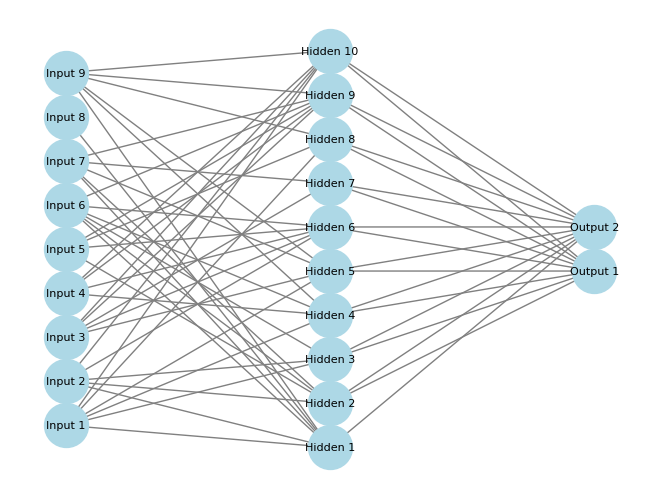

In [ ]:
algorithms[0].plot_network(x_train, y_train)

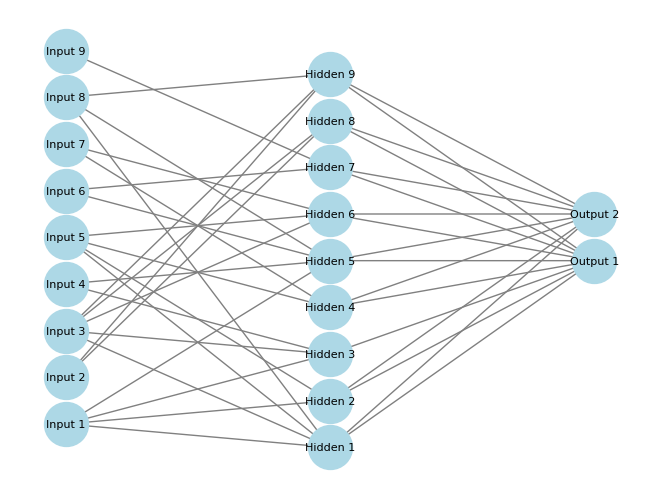

In [ ]:
algorithms[1].plot_network(x_train, y_train)

In [ ]:
algorithms[0].forward(x_train[0],y_train[0])

(0.08803985472274763, array([0.67617425, 0.26686437]))

In [ ]:
print(algorithms[0].best_nn.input_weights)

[[ 0.72559132 -0.14230733  0.          0.          0.         -0.12461118
   0.76089909  0.18843802  1.04776854]
 [ 0.          0.09966182  0.          0.         -0.97987215 -0.9116815
   0.43048571  0.          0.        ]
 [ 0.79755753 -0.40990338  0.          0.          0.          0.3024904
   0.          0.          0.        ]
 [-1.04286625  0.          0.          0.77938818  0.         -0.48737885
   0.          0.         -0.56954879]
 [-0.46014122  0.         -0.92766907  0.          0.          0.
  -0.05670542  0.          0.90889732]
 [ 0.         -0.16506259 -0.17029539 -1.48101727  0.88687544 -0.29157303
   0.          0.          0.        ]
 [ 0.          0.          0.34642899  0.          0.          0.
   0.65850585  0.          0.        ]
 [-0.31505821  0.          0.          0.          0.32152435  0.
   0.          0.          0.41409661]
 [ 0.          0.         -0.60767387  0.98384721  0.26388471 -0.79982685
  -0.11197524  0.          0.47863676]
 [-0.8371

In [ ]:
print(algorithms[0].best_nn.output_weights)

[[ 0.          0.30283269 -0.21036853 -0.18865833  0.54111463  0.90714474
   0.1270361  -1.1960805   0.45627721  0.86104811]
 [ 0.61825358 -0.14801932 -0.45331467  0.34580786 -0.86830996 -0.77566145
   0.02289957  0.69552859 -0.74438155 -0.89330357]]


Выводим изменение среднеквадратичной ошибки (приспособленности) лучшей нейронной сети в процессе эволюции

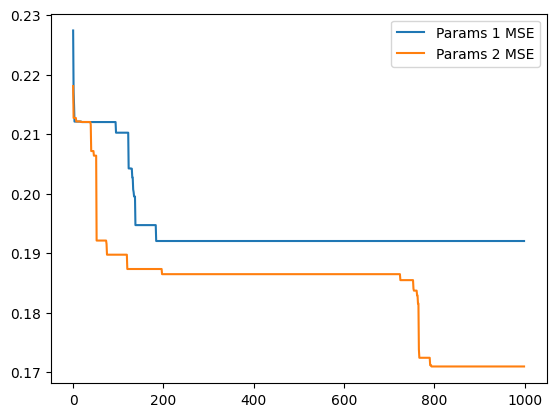

In [ ]:
legend = []
for i in range(len(results)):
    plt.plot(results[i])
    legend.append("Params " + str(i+1) + " MSE")
plt.legend(legend)
plt.show()

Загружаем тестовые данные

In [ ]:
x_test, y_test = cancer1_dataset.get_test_data()

In [ ]:
y_test[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]])

Пропускаем тестовые данные через лучшие нейросети

In [ ]:
results = []
for algorithm in algorithms:
    result = algorithm.test(
        x_test=x_test,
        y_test=y_test)
    results.append(result)

Выводим среднеквадратичную ошибку для каждой тестовой выборки

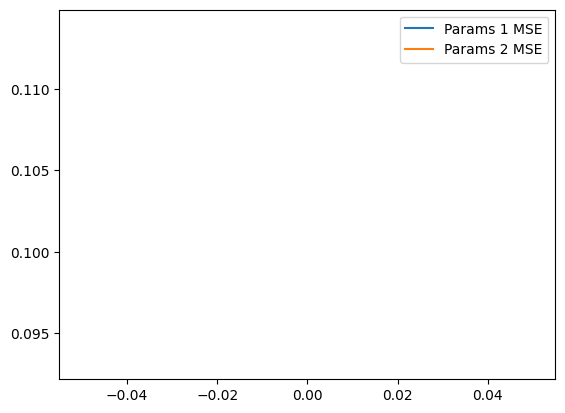

In [ ]:
legend = []
for i in range(len(results)):
    result
    plt.plot(results[0][i][0])
    legend.append("Params " + str(i+1) + " MSE")
plt.legend(legend)
plt.show()

In [ ]:
import pickle

# Получение весов модели
weights = algorithm[0].get_weights()

# Сохранение весов
with open('algorithm[0]_weights.pickle', 'wb') as file:
    pickle.dump(weights, file)


In [ ]:
# Загрузка весов
with open('model_weights.pickle', 'rb') as file:
    weights = pickle.load(file)

# Применение весов к модели
# model.set_weights(weights)